In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
import glob
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv("/content/drive/MyDrive/Smart Farm/Data/concat_df_real.csv").drop(['Unnamed: 0'], axis=1)
df.shape

(18720, 54)

In [74]:
org_data=pd.read_csv("/content/drive/MyDrive/Smart Farm/Data/smart_farm_final.csv")
org_data.shape

(148168, 57)

In [5]:
len(org_data['배기팬'][129449:])

18719

In [8]:
org_data.columns

Index(['시간', '년도', '월', '일', '시', '분', '일사량(W/㎡)', '외기온(℃)', '외기습도(%)',
       '풍속(m/s)', '풍향(º)', '내부 온도', '내부 습도', '차광스크린(수평)', '차열스크린(수평)',
       '에너지스크린(수평)', '에너지스크린(수직)', '배기팬', '천창', '유동팬', '팬코일 B동',
       '환기온도(천창 제어온도)', '난방온도(설정온도)', '열공급량(kWh)', '누적강수량', '현지기압', '해면기압',
       '일조', '년월일', 'PM10_1시간', 'PM25_1시간', '오존_1시간', '이산화질소_1시간', '일산화탄소_1시간',
       '아황산가스_1시간', '차광스크린_개방', '차광스크린_광도조절', '차광스크린_개방조절', '차열스크린_온도조절',
       '차열스크린_광도조절', '차열스크린_개방조절', '일출시간', '일몰시간', '일출3시간후', '일출1시간후',
       '일몰3시간후', '일몰1시간반전', '하루길이', '시간범주', '일몰전후', '일출일몰', '지면온도', '오존등급',
       '아황산가스등급', '이산화질소등급', 'PM10등급', 'PM25등급'],
      dtype='object')

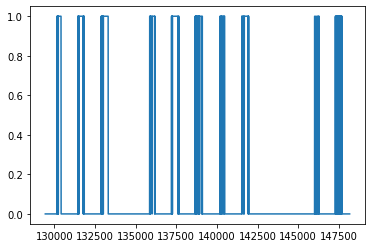

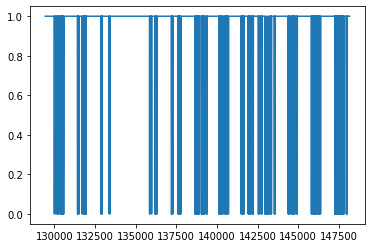

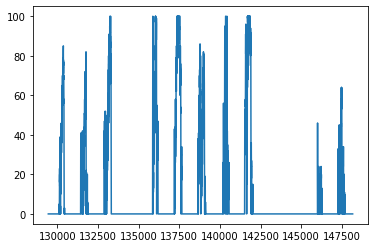

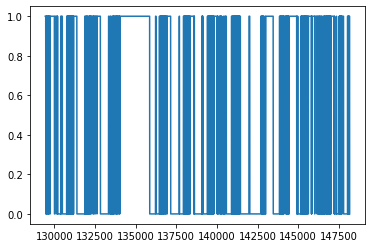

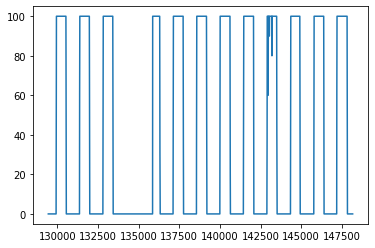

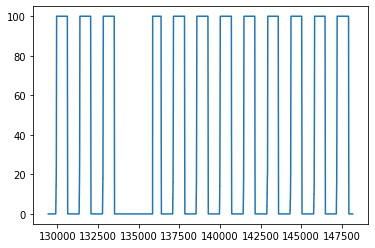

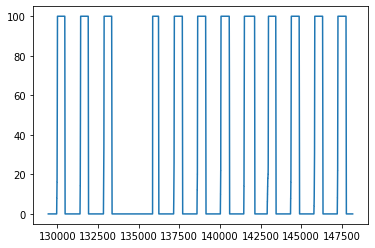

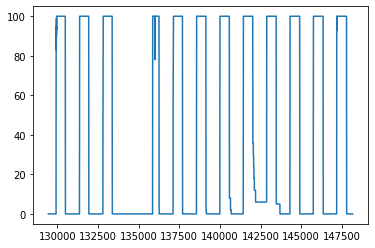

In [9]:
for col in ['배기팬','유동팬','천창','팬코일 B동','차광스크린(수평)','차열스크린(수평)','에너지스크린(수평)','에너지스크린(수직)']:
  plt.plot(org_data[col][129449:])
  plt.show()

In [10]:
org_data['배기팬'][129448:]=-1
org_data['유동팬'][129448:]=-1
org_data['팬코일 B동'][129448:]=-1
org_data['천창'][129448:]=-1
org_data['에너지스크린(수평)'][129448:]=-1
org_data['에너지스크린(수직)'][129448:]=-1
org_data['차광스크린(수평)'][129448:]=-1
org_data['차열스크린(수평)'][129448:]=-1

In [12]:
for i in range(len(df)):
  org_data['내부 온도'].iloc[129448+i]=df['내부 온도'].iloc[i]
  if df['배기팬_1'].iloc[i]==1: org_data['배기팬'].iloc[129448+i]=1
  else: org_data['배기팬'][129448+i]=0
  if df['유동팬_0'].iloc[i]==1: org_data['유동팬'][129448+i]=0
  else: org_data['유동팬'][129448+i]=1
  if df['팬코일 B동_0.0'].iloc[i]==1: org_data['팬코일 B동'][129448+i]=0.0
  else: org_data['팬코일 B동'][129448+i]=1.0

  if df['천창'].iloc[i]==100: org_data['천창'][129448+i]=100
  else: org_data['천창'][129448+i]=0

  if df['에너지스크린(수평)'].iloc[i]==100: org_data['에너지스크린(수평)'][129448+i]=100
  else: org_data['에너지스크린(수평)'][129448+i]=0
  if df['에너지스크린(수직)'].iloc[i]==100: org_data['에너지스크린(수직)'][129448+i]=100
  else: org_data['에너지스크린(수직)'][129448+i]=0
  if df['차광스크린(수평)'].iloc[i]==100: org_data['차광스크린(수평)'][129448+i]=100
  else: org_data['차광스크린(수평)'][129448+i]=0
  if df['차열스크린(수평)'].iloc[i]==100: org_data['차열스크린(수평)'][129448+i]=100
  else: org_data['차열스크린(수평)'][129448+i]=0

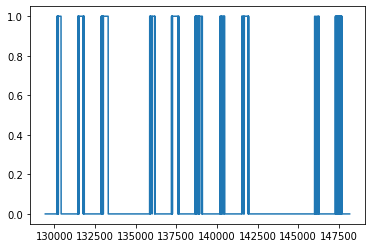

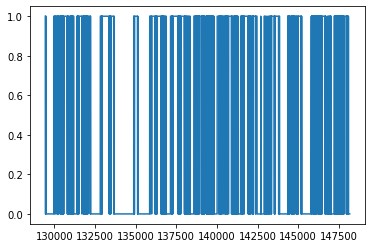

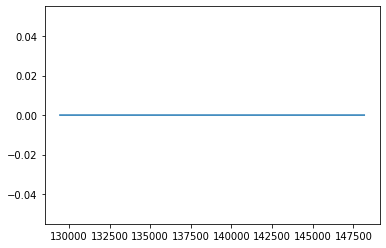

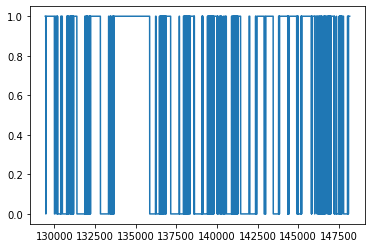

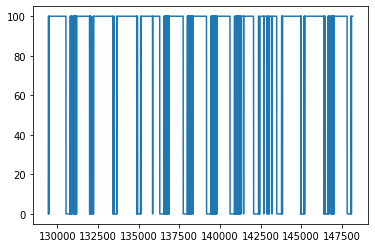

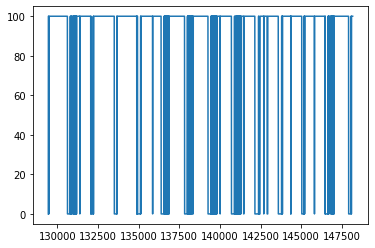

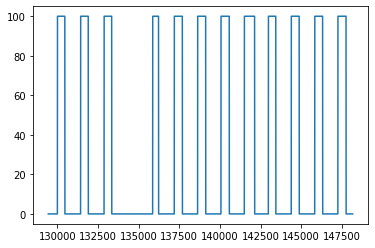

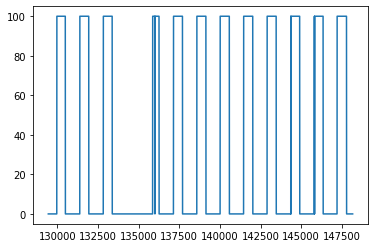

In [13]:
for col in ['배기팬','유동팬','천창','팬코일 B동','차광스크린(수평)','차열스크린(수평)','에너지스크린(수평)','에너지스크린(수직)']:
  plt.plot(org_data[col][129448:])
  plt.show()

### 각도 조절(천창, 스크린들)
- 각 창별 극대, 극소 구간에 대한 평균 변화량을 구해서 변동을 조절

In [ ]:
delta_avgs={}
deltas={}

for col in ['천창', '차광스크린(수평)','차열스크린(수평)','에너지스크린(수평)','에너지스크린(수직)']:
  minmax_idx=[]
  # 극대/극소 구하기
  for i in range(1, 129448-1):
    # org_data[i]가 극소: 경계에 같은거 하나 있는거 포함
    if (org_data[col][i-1]>org_data[col][i] and org_data[col][i+1]>=org_data[col][i]) or (org_data[col][i-1]>=org_data[col][i] and org_data[col][i+1]>org_data[col][i]):
      minmax_idx.append(i)
    # org_data[i]가 극대
    elif (org_data[col][i-1]<org_data[col][i] and org_data[col][i+1]<=org_data[col][i]) or (org_data[col][i-1]<=org_data[col][i] and org_data[col][i+1]<org_data[col][i]):
      minmax_idx.append(i)
  # 극대 극소 별 변화량 평균 구하기
  delta=[]
  for i in range(1, len(minmax_idx)):
    # 변화량의 절대값을 넷째자리에서 반올림
    delta_tmp=round(abs((org_data[col][minmax_idx[i]]-org_data[col][minmax_idx[i-1]])/(minmax_idx[i]-minmax_idx[i-1])), 3)
    if delta_tmp>2.0: # 변화량 2보다 작은거
      delta.append(delta_tmp)
  delta.sort()
  #delta=delta[int(len(delta)*2/3):] # 앞에 2/3 삭제
  delta_avgs[col]=np.mean(delta)
  deltas[col]=delta

In [17]:
for col in ['천창', '차광스크린(수평)','차열스크린(수평)','에너지스크린(수평)','에너지스크린(수직)']: #delta_avgs
  for i in range(len(df)-1):
    if org_data[col][129448+i+1]==0: # 감소
      org_data[col][129448+i+1]=org_data[col][129448+i]-delta_avgs[col]
    elif org_data[col][129448+i+1]==100: # 증가
      org_data[col][129448+i+1]=org_data[col][129448+i]+delta_avgs[col]
    # 0 ~ 100 유지
    if org_data[col][129448+i+1]>100: org_data[col][129448+i+1]=100
    if org_data[col][129448+i+1]<0: org_data[col][129448+i+1]=0

In [19]:
org_data.to_csv("/content/drive/MyDrive/Smart Farm/Data/smart_farm_final_ver3.csv")

# 절감 확인

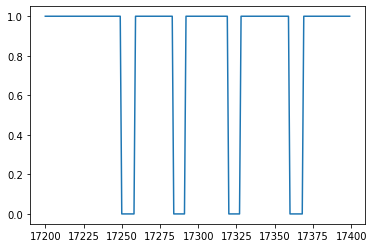

In [126]:
plt.plot(smart_farm_final_scaled_ver8['팬코일 B동'][17200:17400])

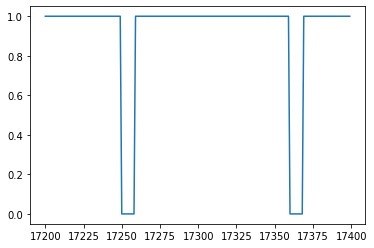

In [127]:
plt.plot(data_scaled_final['팬코일 B동'][17200:17400])

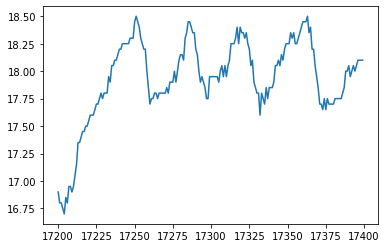

In [128]:
org_datas=org_data[129448:]
org_datas.reset_index(drop=True, inplace=True)
plt.plot(org_datas['내부 온도'][17200:17400])

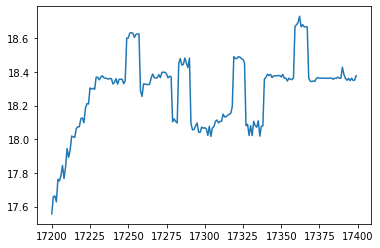

In [131]:
df.reset_index(drop=True, inplace=True)
plt.plot(df['내부 온도'][17200:17400])